In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

import pandas as pd
import numpy as np
import scipy.optimize as opt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
master_path = os.getcwd()
if master_path not in sys.path:
    sys.path.append(master_path)

In [3]:
def parse_folder_info(path):
    folders = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path, f))]
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if('.DS_Store' in files):
        files.remove('.DS_Store')
    if('._.DS_Store' in files):
        files.remove('._.DS_Store')
    return folders, files

In [4]:
def get_time_columns(columns):
    time_str = []
    time_datetime = []
    for col in columns:
        if col[0].isnumeric():
            time_str.append(col)
            time_datetime.append(datetime.datetime.strptime(col, '%m/%d/%y'))
    return time_str, time_datetime

In [5]:
def format_fn(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(time_str)):
        return time_str[int(tick_val)]
    else:
        return int(tick_val)

In [6]:
def autolabel(rects, ax, str_format):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str_format.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [7]:
def exp_growth(t, r, x0):
#     return np.log10(x0) + t * np.log10(1+r)
    return x0 * (1 + r) ** t

In [8]:
def logistic_growth(t, r, K, P0):
    return K / (1 + (K - P0)/P0 * np.exp(-r*t))

In [9]:
cat_color = {'Confirmed':'tab:blue', 'Deaths':'tab:orange', 'Recovered':'tab:green', 'Active':'tab:red'}

In [10]:
path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')

In [11]:
folders, files = parse_folder_info(path_time_series)
df_time_series = pd.DataFrame()
# df_time_series_reorged = pd.DataFrame(columns = ['Country/Region', 'Province/State', 'Date', 'Category', 'Number'])
for file_name in files:
    if('.csv' in file_name):
        df_current = pd.read_csv(os.path.join(path_time_series, file_name))        
        category = file_name[21:file_name.index('.csv')]
        print(category)
        df_current.loc[:,'Category'] = category
        if df_time_series.empty:
            df_time_series = df_current
        else:
            df_time_series = df_time_series.append(df_current, ignore_index = True)

time_str, time_datetime = get_time_columns(df_time_series.columns)

Confirmed
Deaths
Recovered


In [12]:
df_time_series.loc[:,'New Today'] = df_time_series.loc[:,time_str[-1]] - df_time_series.loc[:,time_str[-2]]

In [13]:
""" Total Recovered, death, and confirmed """

' Total Recovered, death, and confirmed '

In [14]:
total = df_time_series.groupby('Category').sum().loc[:,time_str]
mainland_china = df_time_series.groupby('Country/Region').get_group('Mainland China').groupby('Category').sum().loc[:,time_str]
row = total - mainland_china
hubei = df_time_series.groupby('Country/Region').get_group('Mainland China').groupby('Province/State').get_group('Hubei').groupby('Category').sum().loc[:,time_str]
china_others = mainland_china - hubei

total.loc['Active',:] = total.loc['Confirmed',:] - (total.loc['Recovered',:] + total.loc['Deaths',:])
mainland_china.loc['Active',:] = mainland_china.loc['Confirmed',:] - (mainland_china.loc['Recovered',:] + mainland_china.loc['Deaths',:])
row.loc['Active',:] = row.loc['Confirmed',:] - (row.loc['Recovered',:] + row.loc['Deaths',:])
hubei.loc['Active',:] = hubei.loc['Confirmed',:] - (hubei.loc['Recovered',:] + hubei.loc['Deaths',:])
china_others.loc['Active',:] = china_others.loc['Confirmed',:] - (china_others.loc['Recovered',:] + china_others.loc['Deaths',:])

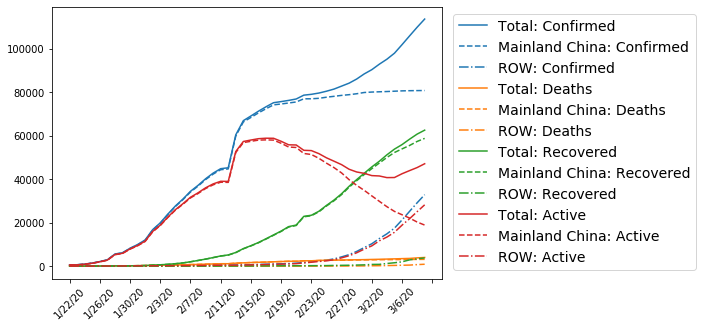

In [15]:
fig, ax1 = plt.subplots(1,1,figsize = (7,5))
for cat in cat_color:
    ax1.plot(total.groupby('Category').get_group(cat).sum()[time_str], color = cat_color[cat])
    ax1.plot(mainland_china.groupby('Category').get_group(cat).sum()[time_str], '--', color = cat_color[cat])
    ax1.plot(row.groupby('Category').get_group(cat).sum()[time_str], '-.', color = cat_color[cat])
legend = ['Total: Confirmed',
         'Mainland China: Confirmed',
          'ROW: Confirmed',
         'Total: Deaths',
         'Mainland China: Deaths',
          'ROW: Deaths',
         'Total: Recovered',
         'Mainland China: Recovered',
          'ROW: Recovered',
         'Total: Active',
         'Mainland China: Active',
         'ROW: Active']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
# ax1.set_title('Total', size = 18)
plt.legend(legend, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize = 14)

Text(0.5, 1.0, 'ROW: 32848')

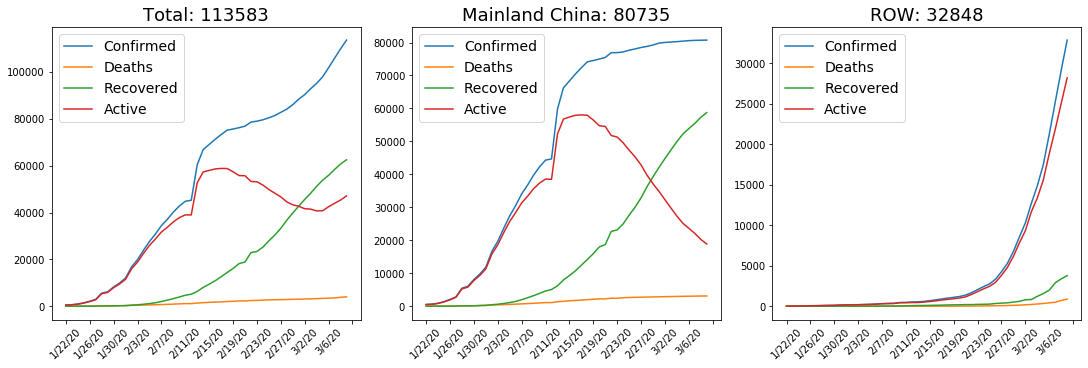

In [16]:
fig = plt.figure(figsize = (15, 5), constrained_layout=True)
gs = fig.add_gridspec(1,3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(total.transpose())
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(total.index, fontsize = 14)
ax1.set_title(f'Total: {int(total.loc["Confirmed",time_str[-1]])}', size = 18)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(mainland_china.transpose())
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(mainland_china.index, fontsize = 14)
ax2.set_title(f'Mainland China: {int(mainland_china.loc["Confirmed",time_str[-1]])}', size = 18)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(row.transpose())
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(row.index, fontsize = 14)
ax3.set_title(f'ROW: {int(row.loc["Confirmed",time_str[-1]])}', size = 18)

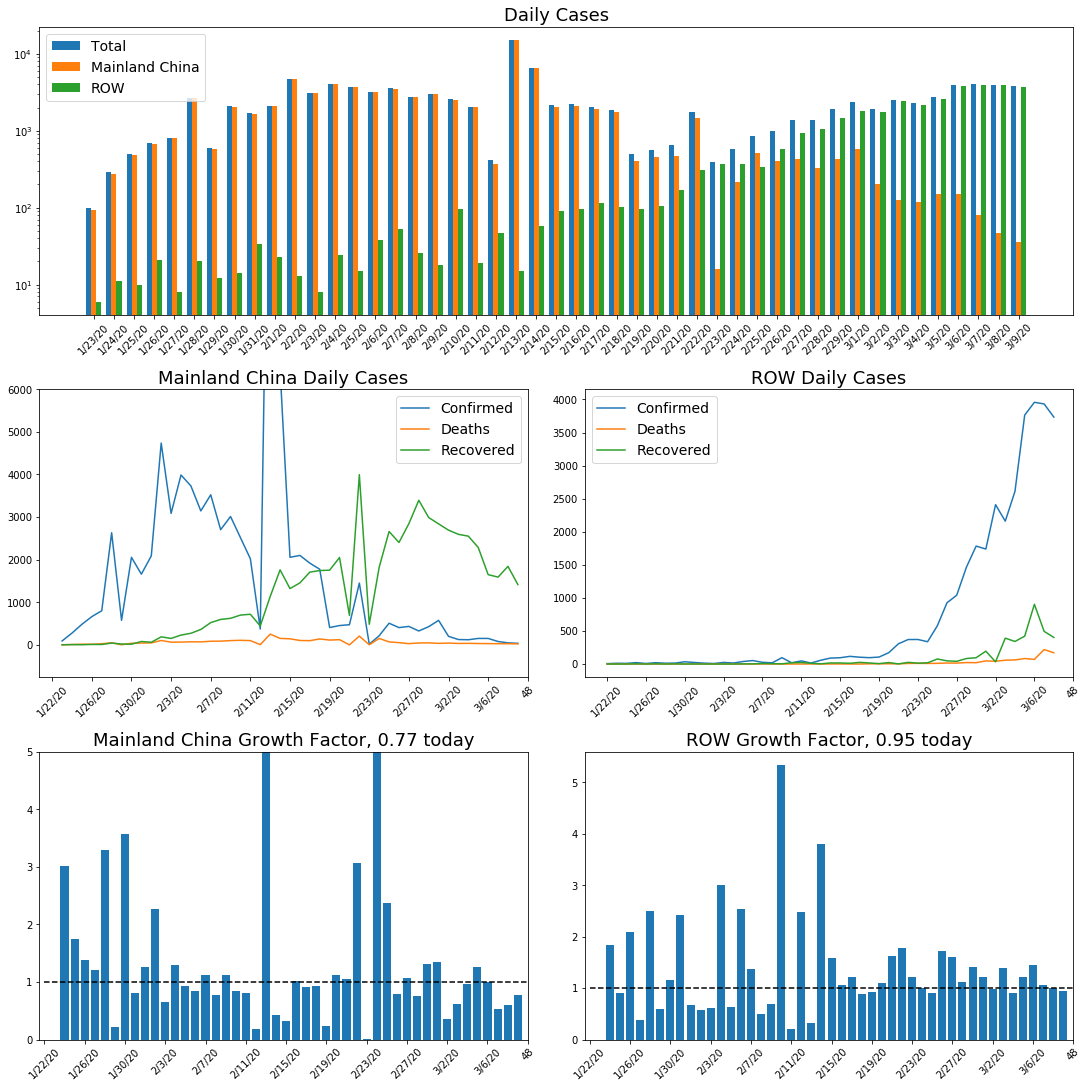

In [82]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3,2)

### Mainland China daily confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(1, len(np.transpose(mainland_china.to_numpy())[1:,:-1])+1)
ax2.plot(x, np.transpose(mainland_china.to_numpy())[1:,:-1] - np.transpose(mainland_china.to_numpy())[:-1,:-1])
_ = ax2.set_xticklabels(time_str[1:])
ytick_list = time_str[1:]
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_ylim(top = 6000)
ax2.set_xlim(right = len(time_str))
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(mainland_china.index, fontsize = 14)
ax2.set_title('Mainland China Daily Cases', size = 18)

### ROW daily confirmed/recovered/deaths/active
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(np.transpose(row.to_numpy())[1:,:-1] - np.transpose(row.to_numpy())[:-1,:-1])
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_xlim(right = len(time_str))
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(row.index, fontsize = 14)
ax3.set_title('ROW Daily Cases', size = 18)

### Daily Confirmed cases
ax4 = fig.add_subplot(gs[0, :])

total_daily = total.loc['Confirmed',:].to_numpy()[1:] - total.loc['Confirmed',:].to_numpy()[:-1]
mc_daily = mainland_china.loc['Confirmed',:].to_numpy()[1:] - mainland_china.loc['Confirmed',:].to_numpy()[0:-1]
row_daily = row.loc['Confirmed',:].to_numpy()[1:] - row.loc['Confirmed',:].to_numpy()[0:-1]
x = np.arange(len(total_daily))
width = 0.25

ax4.bar(x + 0, total_daily, width = width)
ax4.bar(x + width*1, mc_daily, width = width)
ax4.bar(x + width*2, row_daily, width = width)
ax4.set_yscale('log')
# ax4.set_ylim([0, 5000])
_ = ax4.set_xticks(x + width)
_ = ax4.set_xticklabels(time_str[1:])
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(['Total', 'Mainland China', 'ROW'], fontsize = 14, loc='upper left')
ax4.set_title('Daily Cases', size = 18)

### Mainland China Growth Factor
ax5 = fig.add_subplot(gs[2, 0])
gf_mc = mc_daily[1:] / mc_daily[:-1]
gf_mc[~np.isfinite(gf_mc)] = 0
x = np.arange(2, len(gf_mc)+2)
x1 = np.arange(0, len(time_str) + 2)

ax5.bar(x, gf_mc)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)])
ax5.set_ylim(top = 5, bottom = 0)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.set_title(f'Mainland China Growth Factor, {gf_mc[-1]:.2f} today', size = 18)

### ROW Growth Factor
ax6 = fig.add_subplot(gs[2, 1])
gf_row = row_daily[1:] / row_daily[:-1]
gf_row[~np.isfinite(gf_row)] = 0

ax6.bar(x, gf_row)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(time_str)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'ROW Growth Factor, {gf_row[-1]:.2f} today', size = 18)

Fatality rate in Mainland China (outside Hubei): 0.86%
Fatality rate in rest of the world: 2.67%


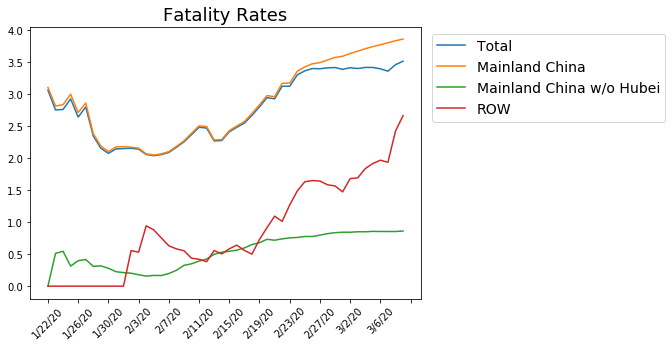

In [19]:
fatal_rate = total.loc['Deaths',time_str] / total.loc['Confirmed',time_str]

fig, ax1 = plt.subplots(1,1,figsize = (7,5))

ax1.plot(total.loc['Deaths',time_str] / total.loc['Confirmed',time_str] * 100)
ax1.plot(mainland_china.loc['Deaths',time_str] / mainland_china.loc['Confirmed',time_str] * 100)
ax1.plot(china_others.loc['Deaths',time_str] / china_others.loc['Confirmed',time_str] * 100)
ax1.plot(row.loc['Deaths',time_str] / row.loc['Confirmed',time_str] * 100)
plt.legend(['Total',
            'Mainland China',
            'Mainland China w/o Hubei',
            'ROW'
           ], bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize = 14)
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
plt.title('Fatality Rates', fontsize = 18)

dr1 = china_others.loc['Deaths', time_str[-1]]/china_others.loc['Confirmed', time_str[-1]] * 100
dr2 = row.loc['Deaths', time_str[-1]]/row.loc['Confirmed', time_str[-1]] * 100
print(f'Fatality rate in Mainland China (outside Hubei): {dr1:.2f}%')
print(f'Fatality rate in rest of the world: {dr2:.2f}%')

In [20]:
"""US"""

'US'

In [21]:
df_US = df_time_series.groupby(['Country/Region']).get_group(('US'))
df_Ca = pd.DataFrame()
df_DP = pd.DataFrame()
df_USmain = pd.DataFrame()
df_GP = pd.DataFrame()

for i in df_US.index:
    if ('CA' in df_US.loc[i, 'Province/State']):
        if('(From Diamond Princess)' not in df_US.loc[i, 'Province/State']) :
            df_Ca = df_Ca.append(df_US.loc[i,:])
    if('(From Diamond Princess)'in df_US.loc[i, 'Province/State']) :
        df_DP = df_DP.append(df_US.loc[i,:])
    if('Grand Princess' in df_US.loc[i, 'Province/State']):
        df_GP = df_GP.append(df_US.loc[i,:])
    else:
        df_USmain = df_USmain.append(df_US.loc[i,:])

df_US_sum = df_US.groupby('Category').sum().loc[:,time_str]
df_Ca_sum = df_Ca.groupby('Category').sum().loc[:,time_str]
df_DP_sum = df_DP.groupby('Category').sum().loc[:,time_str]
df_USmain_sum = df_USmain.groupby('Category').sum().loc[:,time_str]
df_GP_sum = df_GP.groupby('Category').sum().loc[:,time_str]

df_US_sum.loc['Active',:] = df_US_sum.loc['Confirmed',:] - (df_US_sum.loc['Recovered',:] + df_US_sum.loc['Deaths',:])
df_Ca_sum.loc['Active',:] = df_Ca_sum.loc['Confirmed',:] - (df_Ca_sum.loc['Recovered',:] + df_Ca_sum.loc['Deaths',:])
df_DP_sum.loc['Active',:] = df_DP_sum.loc['Confirmed',:] - (df_DP_sum.loc['Recovered',:] + df_DP_sum.loc['Deaths',:])
df_USmain_sum.loc['Active',:] = df_USmain_sum.loc['Confirmed',:] - (df_USmain_sum.loc['Recovered',:] + df_USmain_sum.loc['Deaths',:])
df_GP_sum.loc['Active',:] = df_GP_sum.loc['Confirmed',:] - (df_GP_sum.loc['Recovered',:] + df_GP_sum.loc['Deaths',:])

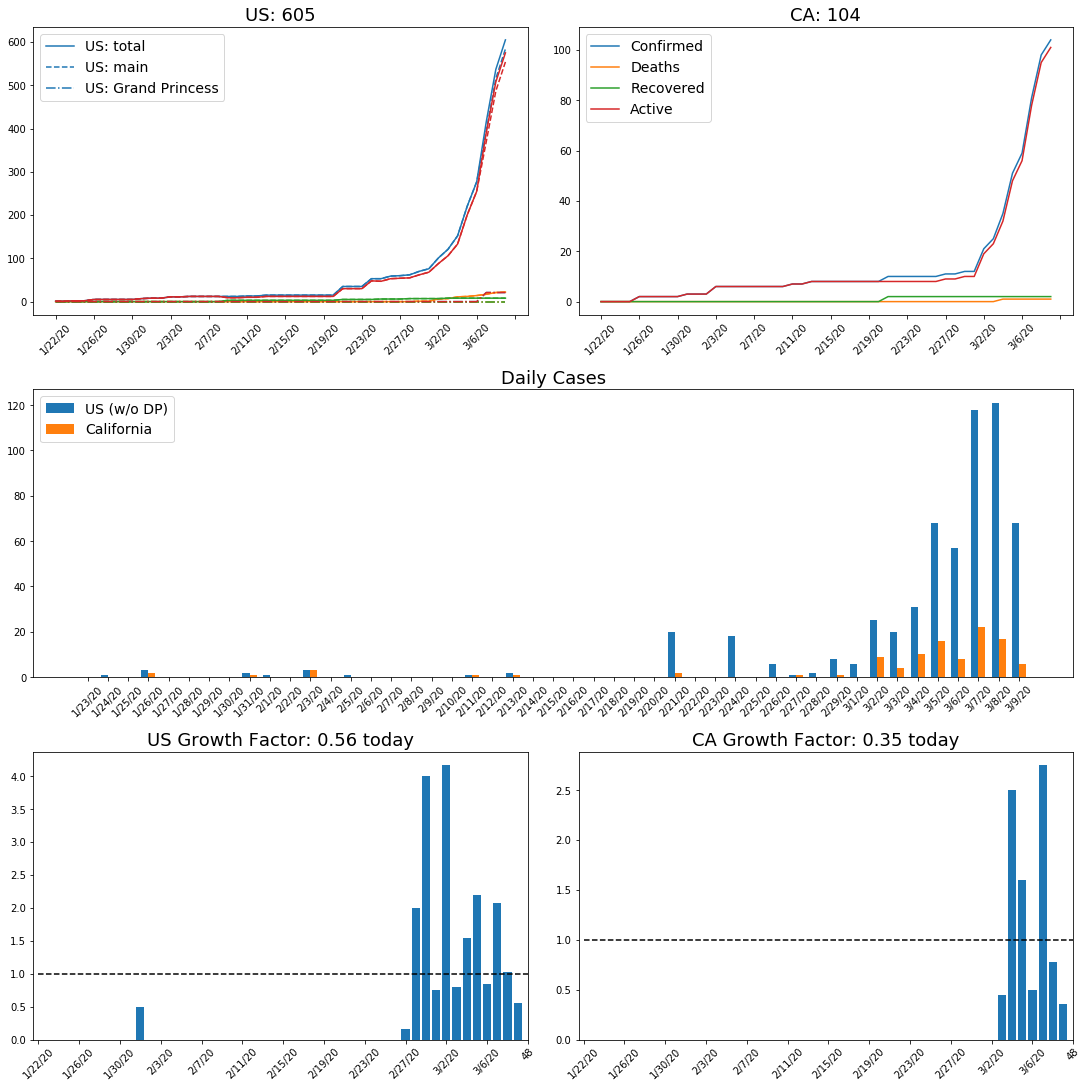

In [78]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3,2)

### US confirmed/recovered/deaths/active
ax1 = fig.add_subplot(gs[0, 0])
for cat in cat_color:
    ax1.plot(df_US_sum.loc[cat,:].transpose(), color = cat_color[cat])
    ax1.plot(df_USmain_sum.loc[cat,:].transpose(), '--', color = cat_color[cat])
    ax1.plot(df_GP_sum.loc[cat,:].transpose(), '-.', color = cat_color[cat])
legend = ['US: total', 'US: main', 'US: Grand Princess']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(legend, fontsize = 14)
ax1.set_title(f'US: {int(df_US_sum.loc["Confirmed",time_str[-1]])}', size = 18)

              
### Ca confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_Ca_sum.transpose())
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(df_Ca_sum.index, fontsize = 14)
ax2.set_title(f'CA: {int(df_Ca_sum.loc["Confirmed",time_str[-1]])}', size = 18)

              
### Daily new cases              
ax3 = fig.add_subplot(gs[1, :])
usmain_daily = df_USmain_sum.loc['Confirmed',:].to_numpy()[1:] - df_USmain_sum.loc['Confirmed',:].to_numpy()[0:-1] 
ca_daily = df_Ca_sum.loc['Confirmed',:].to_numpy()[1:] - df_Ca_sum.loc['Confirmed',:].to_numpy()[0:-1] 
x = np.arange(len(usmain_daily))
width = 0.35
rects1 = ax3.bar(x - width/2, usmain_daily, width = width)
rects2 = ax3.bar(x + width/2, ca_daily, width = width)
ax3.set_yscale('linear')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 1000])
_ = ax3.set_xticks(x)
_ = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['US (w/o DP)', 'California'], fontsize = 14)
ax3.set_title('Daily Cases', size = 18)

              
### US growth factors
ax4 = fig.add_subplot(gs[2, 0])
              
usmain_gf = usmain_daily[1:] / usmain_daily[:-1]
usmain_gf[~np.isfinite(usmain_gf)] = 0
x = np.arange(2, len(usmain_gf)+2)
x1 = np.arange(0, len(time_str) + 2)
              
ax4.bar(x, usmain_gf)
ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_xlim([-0.5, len(time_str)])
ax4.tick_params(axis = 'x', labelrotation = 45)
_ = ax4.set_title(f'US Growth Factor: {usmain_gf[-1]:.2f} today', size = 18)

              
### CA growth factors
ax5 = fig.add_subplot(gs[2, 1])
              
ca_gf = ca_daily[1:] / ca_daily[:-1]
ca_gf[~np.isfinite(ca_gf)] = 0
              
ax5.bar(x, ca_gf)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)])
ax5.tick_params(axis = 'x', labelrotation = 45)
_ = ax5.set_title(f'CA Growth Factor: {ca_gf[-1]:.2f} today', size = 18)

In [23]:
x = np.arange(len(time_str))
y = df_USmain_sum.loc['Confirmed',time_str].to_list()

ind_t0 = y.index(next(filter(lambda x: x!=0, y)))
t = np.arange(len(time_str))[ind_t0:] - ind_t0
p_t = df_USmain_sum.loc['Confirmed',time_str].to_numpy()[ind_t0:]
# popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  p_t)
popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  p_t, maxfev=10000)

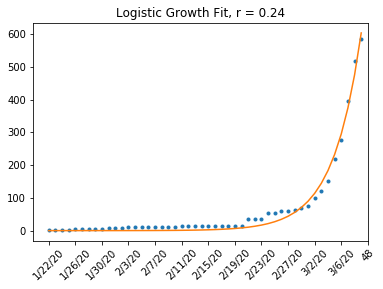

In [24]:
fig, ax = plt.subplots(1, 1)
plt.plot(x, y, '.')
x1 = np.arange(len(time_str) + 10)
plt.plot(t + ind_t0, logistic_growth(t, popt_log[0], popt_log[1], popt_log[2]))
plt.title(f'Logistic Growth Fit, r = {popt_log[0]:.2f}')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax.xaxis.set_major_locator(myLocator)
ax.set_xlim(right = len(time_str))
ax.tick_params(axis = 'x', labelrotation = 45)

https://lmfit.github.io/lmfit-py/model.html

In [27]:
df_Ca_details = df_Ca.groupby('Category').get_group('Confirmed').groupby('Province/State').sum()

In [28]:
df_Ca_details.sort_values(by = ['New Today', time_str[-1]], inplace = True, ascending = [False, False])

In [29]:
df_Ca_details.loc[:,[time_str[-1], 'New Today']]

,3/9/20,New Today
Province/State,,
"Placer County, CA",7.0,2.0
"Sonoma County, CA",3.0,2.0
"Orange County, CA",4.0,1.0
"Shasta County, CA",1.0,1.0
"Santa Clara County, CA",38.0,0.0
"Los Angeles, CA",14.0,0.0
"Contra Costa County, CA",12.0,0.0
"San Francisco County, CA",9.0,0.0
"San Diego County, CA",3.0,0.0


In [30]:
""" Mainland China """

' Mainland China '

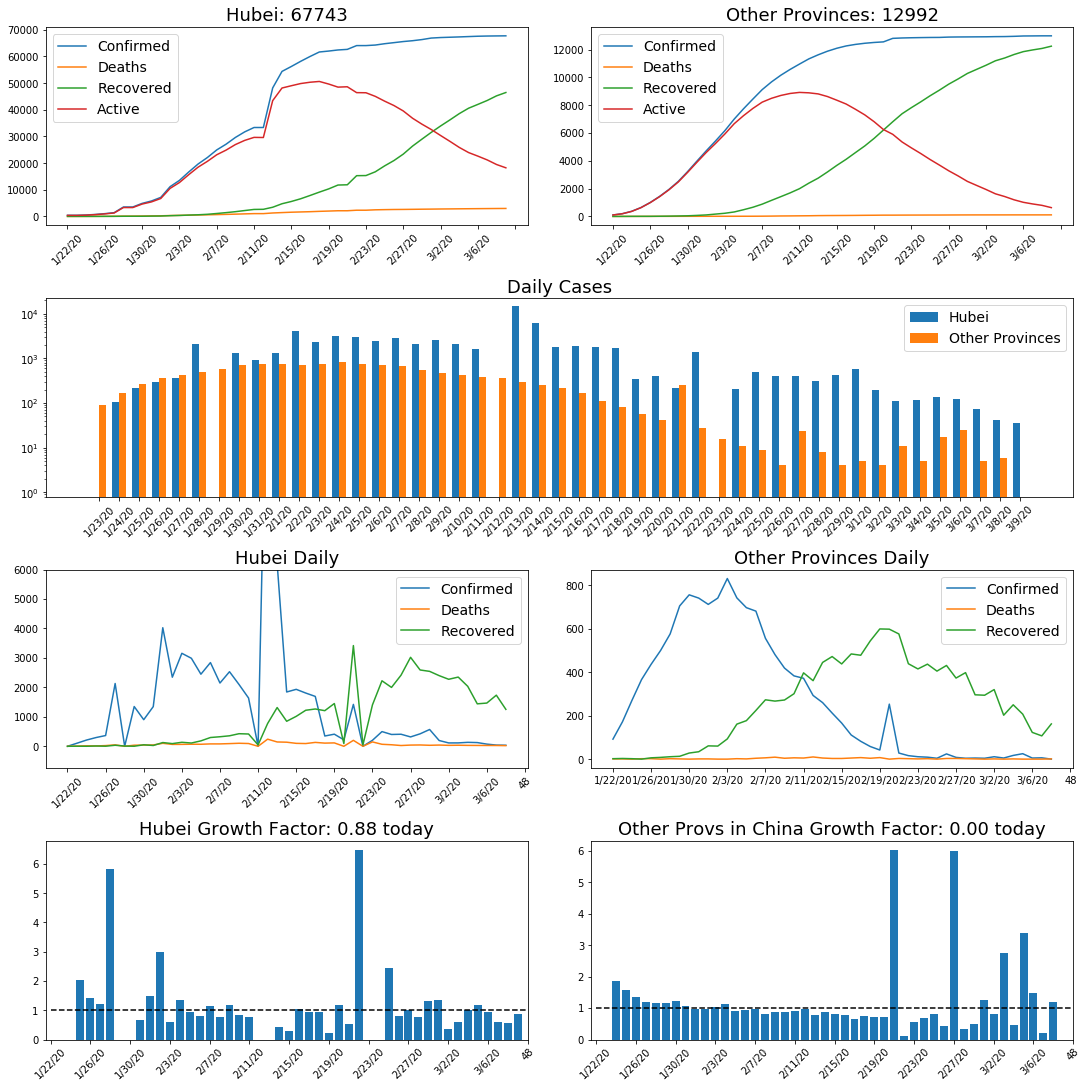

In [76]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(4,2)

### Hubei total confirmed/death/recovered
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(hubei.transpose())
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(hubei.index, fontsize = 14)
ax1.set_title(f'Hubei: {int(hubei.loc["Confirmed",time_str[-1]])}', size = 18)

              
### Other Provinces total confirmed/death/recovered
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(china_others.transpose())
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(china_others.index, fontsize = 14)
ax2.set_title(f'Other Provinces: {int(china_others.loc["Confirmed",time_str[-1]])}', size = 18)

              
### Daily new cases              
ax3 = fig.add_subplot(gs[1, :])
hubei_daily = hubei.loc['Confirmed',:].to_numpy()[1:] - hubei.loc['Confirmed',:].to_numpy()[:-1]
co_daily = china_others.loc['Confirmed',:].to_numpy()[1:] - china_others.loc['Confirmed',:].to_numpy()[0:-1]
x = np.arange(len(hubei_daily))
width = 0.35
rects1 = ax3.bar(x - width/2, hubei_daily, width = width)
rects2 = ax3.bar(x + width/2, co_daily, width = width)
ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 200])
a = ax3.set_xticks(x)
a = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['Hubei', 'Other Provinces'], fontsize = 14)
ax3.set_ylim(bottom = 10**-0.1)
ax3.set_title('Daily Cases', size = 18)

### Hubei daily confirmed/death/recovered              
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(np.transpose(hubei.to_numpy())[1:,:-1] - np.transpose(hubei.to_numpy())[:-1,:-1])
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_ylim(top = 6000)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(mainland_china.index, fontsize = 14)
ax4.set_title('Hubei Daily', size = 18)

### Other provinces daily confirmed/death/recovered              
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(np.transpose(china_others.to_numpy())[1:,:-1] - np.transpose(china_others.to_numpy())[:-1,:-1])
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(china_others.index, fontsize = 14)
ax5.set_title('Other Provinces Daily', size = 18)

### Hubei Growth Factor
ax6 = fig.add_subplot(gs[3, 0])

hubei_gf = hubei_daily[1:] / hubei_daily[:-1]
hubei_gf[~np.isfinite(hubei_gf)] = 0
x = np.arange(2, len(hubei_gf)+2)
x1 = np.arange(0, len(time_str) + 2)

ax6.bar(x, hubei_gf)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(time_str)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'Hubei Growth Factor: {hubei_gf[-1]:.2f} today', size = 18)

              
### Other Provinces Growth Factor
ax7 = fig.add_subplot(gs[3, 1])
              
co_gf = co_daily[1:] / co_daily[:-1]
co_gf[~np.isfinite(co_gf)] = 0
             
ax7.bar(x, co_gf)
ax7.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax7.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.set_xlim([-0.5, len(time_str)])
ax7.tick_params(axis = 'x', labelrotation = 45)
_ = ax7.set_title(f'Other Provs in China Growth Factor: {co_gf[-1]:.2f} today', size = 18)

In [32]:
x = np.arange(len(time_str))
y1 = hubei.loc['Confirmed',time_str].to_list()
y2 = china_others.loc['Confirmed',time_str].to_list()
# popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  p_t)
popt1, pcov1 = opt.curve_fit(logistic_growth,  x,  y1, maxfev=10000)
popt2, pcov2 = opt.curve_fit(logistic_growth,  x,  y2, maxfev=10000)

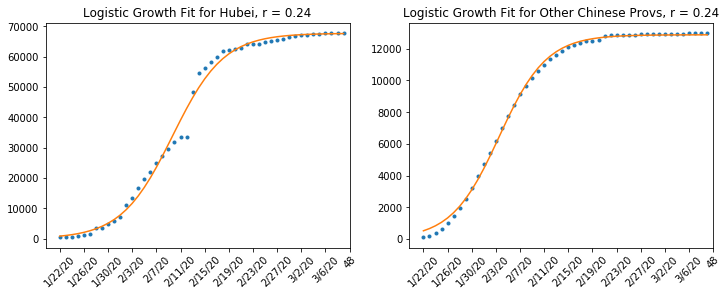

In [33]:
fig = plt.figure(figsize = (10, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
plt.plot(x, y1, '.')
plt.plot(x, logistic_growth(x, popt1[0], popt1[1], popt1[2]))
plt.title(f'Logistic Growth Fit for Hubei, r = {popt1[0]:.2f}')
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
_ = ax1.set_xlim(right = len(time_str))


ax2 = fig.add_subplot(gs[0, 1])
plt.plot(x, y2, '.')
plt.plot(x, logistic_growth(x, popt2[0], popt2[1], popt2[2]))
plt.title(f'Logistic Growth Fit for Other Chinese Provs, r = {popt1[0]:.2f}')
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
_ = ax2.set_xlim(right = len(time_str))

In [34]:
""" Outside Mainland China"""

' Outside Mainland China'

In [35]:
def get_growth_rate(ctry, df_confirmed, time_str):
    x = np.arange(len(time_str))
    y = df_confirmed.loc[ctry,time_str].to_list()

    ind_t0 = y.index(next(filter(lambda x: x!=0, y)))
    t = np.arange(len(time_str))[ind_t0:] - ind_t0
    p_t = df_confirmed.loc[ctry,time_str].to_numpy()[ind_t0:]
    popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  p_t, p0 = (0.1, 100, 1), maxfev=100000)    
    return popt_log[0]

In [36]:
df_confirmed = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country/Region').sum()
df_recovered = df_time_series.groupby('Category').get_group('Recovered').groupby('Country/Region').sum()
df_deaths = df_time_series.groupby('Category').get_group('Deaths').groupby('Country/Region').sum()
df_active = df_confirmed - (df_recovered + df_deaths)

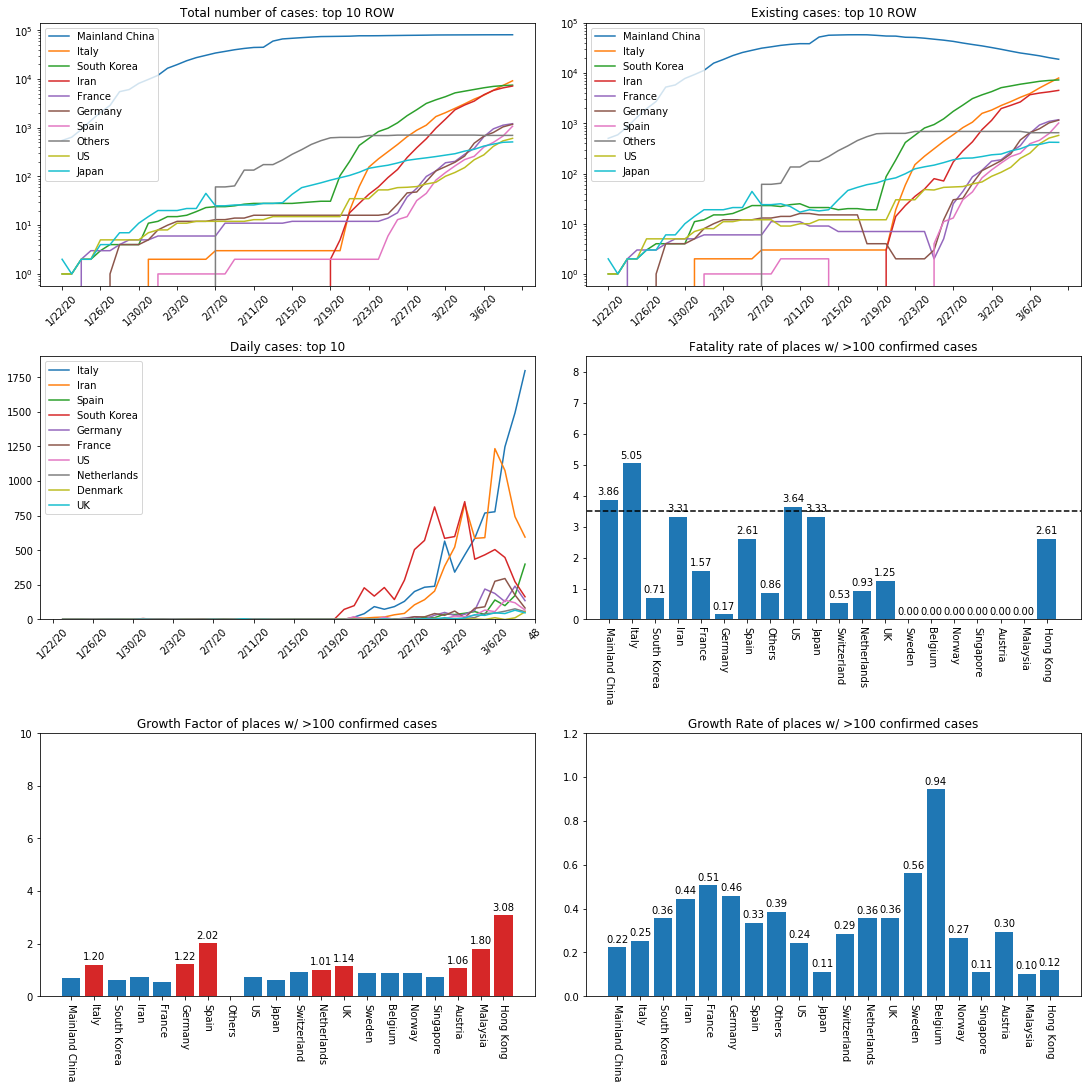

In [73]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3, 2)

### total number
ax1 = fig.add_subplot(gs[0, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
df_plot = df_confirmed.loc[countries,time_str]

ax1.plot(df_plot.transpose())
ax1.legend(countries)
ax1.set_yscale('log')
# plt.ylim(top = 2000)
ax1.set_title('Total number of cases: top 10 ROW')
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)

### existing number
ax3 = fig.add_subplot(gs[0, 1])

df_active.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_active.index[0:10])
df_plot = df_active.loc[countries,time_str]

ax3.plot(df_plot.transpose())
ax3.legend(countries)
ax3.set_yscale('log')
# plt.ylim(top = 2000)
ax3.set_title('Existing cases: top 10 ROW')
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)

### daily cases
ax2 = fig.add_subplot(gs[1, 0])

df_confirmed.sort_values(by = 'New Today', inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
data = df_confirmed.loc[countries,time_str].to_numpy().transpose()
new_today = data[1:,:] - data[0:-1,:]
data_max = np.ceil(np.max(new_today, axis = 1)[-1]/100)*100 + 100

x = np.arange(1, len(time_str))
ax2.plot(x, new_today)
ax2.legend(countries, loc = 'upper left')
ax2.set_yscale('linear')
ax2.set_ylim([0, data_max])
a = ax2.set_title('Daily cases: top 10')
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_xlim(right = len(time_str))
ax2.tick_params(axis = 'x', labelrotation = 45)

### fatality rate
ax4 = fig.add_subplot(gs[1, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 100]
fatal_rates = df_deaths.loc[countries,time_str] / df_confirmed.loc[countries,time_str] * 100
x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+10)
fr_total = (total.loc['Deaths',time_str] / total.loc['Confirmed',time_str] * 100).iloc[-1]

rects = ax4.bar(x, fatal_rates.loc[:,time_str[-1]])
ax4.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(countries)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax4, '{:.2f}')
ax4.set_ylim([0, 8.5])
ax4.set_xlim([-1, len(x) + 0.5])
a = ax4.set_title('Fatality rate of places w/ >100 confirmed cases')

### growth factor
ax5 = fig.add_subplot(gs[2, 0])
x = np.arange(len(countries))
growth_factors = (df_confirmed.loc[countries, time_str[2:]].to_numpy() - df_confirmed.loc[countries, time_str[1:-1]].to_numpy()) \
/(df_confirmed.loc[countries, time_str[1:-1]].to_numpy() - df_confirmed.loc[countries, time_str[:-2]].to_numpy())
y = (growth_factors[:,-1] + growth_factors[:,-2])/2
y[~np.isfinite(y)] = 0

rects = ax5.bar(x[y<=1], y[y<=1], color = 'tab:blue')
rects = ax5.bar(x[y>1], y[y>1], color = 'tab:red')
a = ax5.set_xticks(x)
a = ax5.set_xticklabels(countries)
ax5.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax5, '{:.2f}')
ax5.set_ylim([0, 10])
a = ax5.set_title('Growth Factor of places w/ >100 confirmed cases')

### r for logistic growth fit
ax6 = fig.add_subplot(gs[2, 1])
x = np.arange(len(countries))
y = []
for i in x:
    ctry = countries[i]
    y.append(get_growth_rate(ctry, df_confirmed, time_str))
rects = ax6.bar(x, y)
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(countries)
ax6.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax6, '{:.2f}')
ax6.set_ylim([0, 1.2])
a = ax6.set_title('Growth Rate of places w/ >100 confirmed cases')

In [65]:
np.full(len(x), fr_total)

array([3.51813211, 3.51813211, 3.51813211, 3.51813211, 3.51813211,
       3.51813211, 3.51813211, 3.51813211, 3.51813211, 3.51813211,
       3.51813211, 3.51813211, 3.51813211, 3.51813211, 3.51813211,
       3.51813211, 3.51813211, 3.51813211, 3.51813211, 3.51813211])

In [38]:
### world bar graph

In [39]:
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_recovered.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)

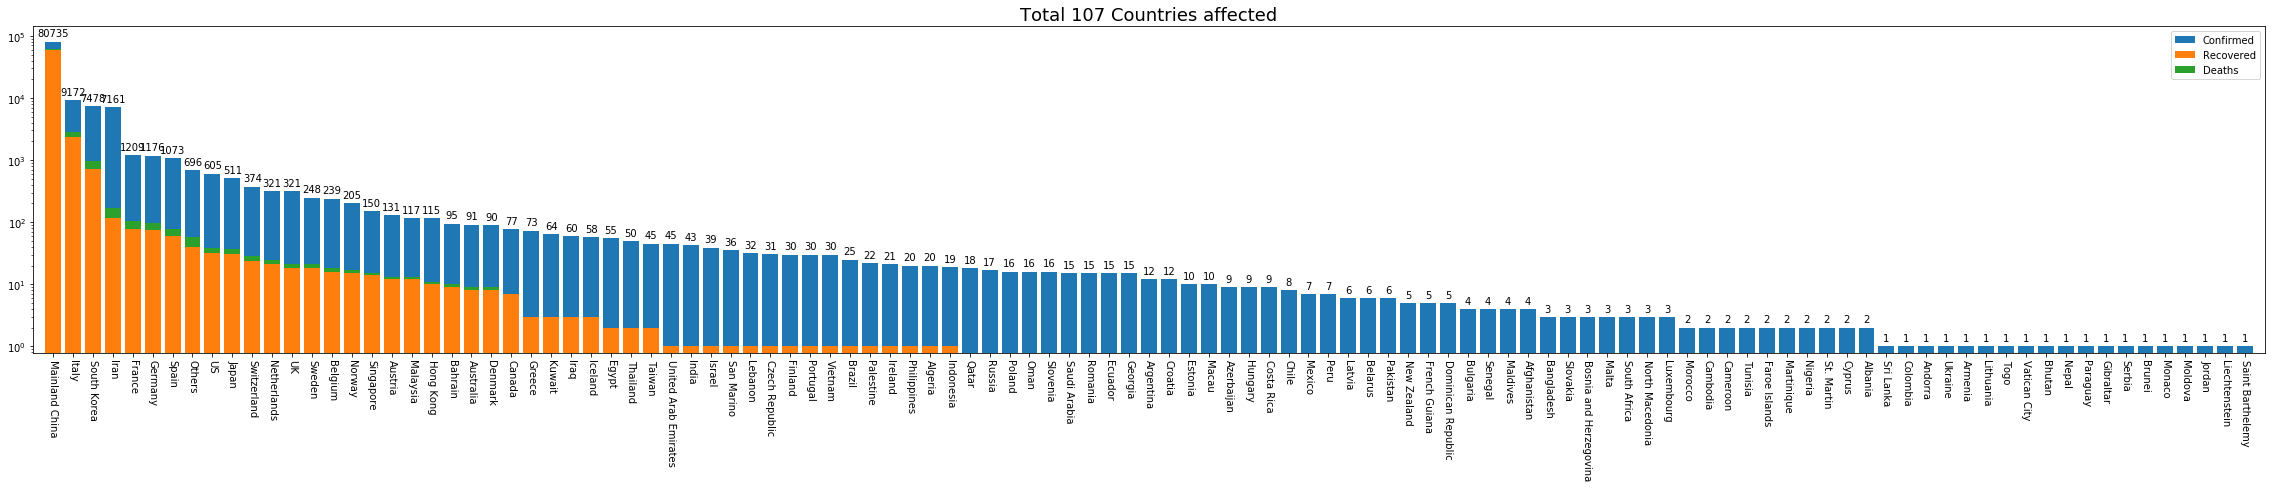

In [54]:
recovered = df_recovered.loc[:,time_str[-1]].to_numpy()
deaths = df_deaths.loc[:,time_str[-1]].to_numpy()
confirmed = df_confirmed.loc[:,time_str[-1]].to_numpy()
x = np.arange(len(confirmed))

fig, ax = plt.subplots(1,1,figsize = (40,6))
rects = ax.bar(x, confirmed)
plt.bar(x, recovered)
plt.bar(x, deaths, bottom = recovered)

plt.legend(['Confirmed', 'Recovered', 'Deaths'])
plt.yscale('log')
plt.ylim(bottom = 10**-0.1)
plt.xlim([-1, len(x)])
a = ax.set_xticks(x)
a = ax.set_xticklabels(list(df_confirmed.index))
a = plt.xticks(rotation=-90)
a = plt.title(f'Total {len(df_confirmed.index)-4} Countries affected', fontsize = 18)
autolabel(rects, ax, '{:.0f}')

In [41]:
""" Specific Countries """

' Specific Countries '

In [50]:
ctry = 'Malaysia'

In [51]:
x = np.arange(len(time_str))
y = df_confirmed.loc[ctry,time_str].to_list()

ind_t0 = y.index(next(filter(lambda x: x!=0, y)))
t = np.arange(len(time_str))[ind_t0:] - ind_t0
p_t = df_confirmed.loc[ctry,time_str].to_numpy()[ind_t0:]
popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  p_t)
popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  p_t, p0 = (0.1, 100, 1), maxfev=100000)

Text(0.5, 1.0, 'Malaysia: growth rate 0.11/0.10')

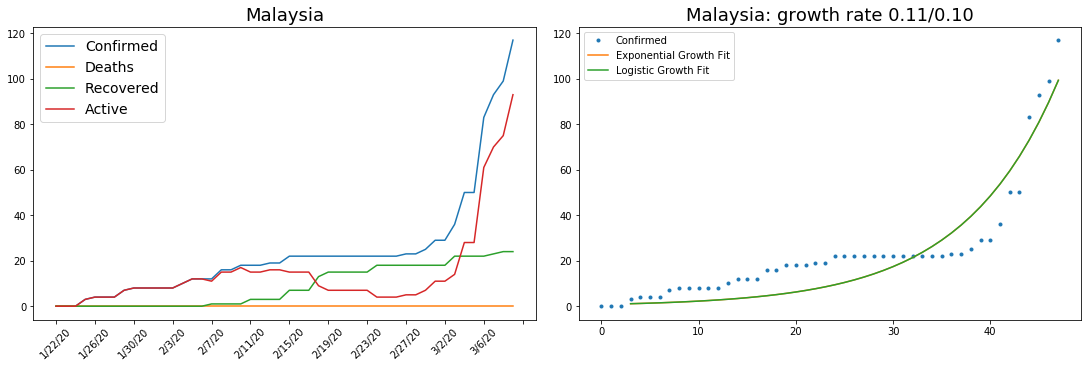

In [52]:
fig = plt.figure(figsize = (15, 5), constrained_layout=True)
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_confirmed.loc[ctry, time_str].transpose())
ax1.plot(df_deaths.loc[ctry, time_str].transpose())
ax1.plot(df_recovered.loc[ctry, time_str].transpose())
ax1.plot(df_active.loc[ctry, time_str].transpose())
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(['Confirmed', 'Deaths', 'Recovered', 'Active'], fontsize = 14)
ax1.set_title(ctry, size = 18)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x, y, '.')
ax2.plot(t + ind_t0, exp_growth(t, popt_exp[0], popt_exp[1]))
ax2.plot(t + ind_t0, logistic_growth(t, popt_log[0], popt_log[1], popt_log[2]))
ax2.set_yscale('linear')
ax2.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'])
ax2.set_title(f'{ctry}: growth rate {popt_exp[0]:.2f}/{popt_log[0]:.2f}', fontsize = 18)